# Average True Range (ATR) Indicator

**Formula**: EMA of True Range, where TR = max(H-L, |H-Cp|, |L-Cp|)

**Interpretation:**
- Higher ATR: Higher volatility
- Lower ATR: Lower volatility
- Rising ATR: Volatility increasing
- Falling ATR: Volatility decreasing

**Key signals**: Use for position sizing and stop-loss placement

In [1]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from indikator import atr

plt.style.use('seaborn-v0_8-darkgrid')
np.random.seed(42)

## Scenario 1: Breakout with Increasing Volatility

/tmp/sselcuk/ipykernel_1244237/2778241686.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


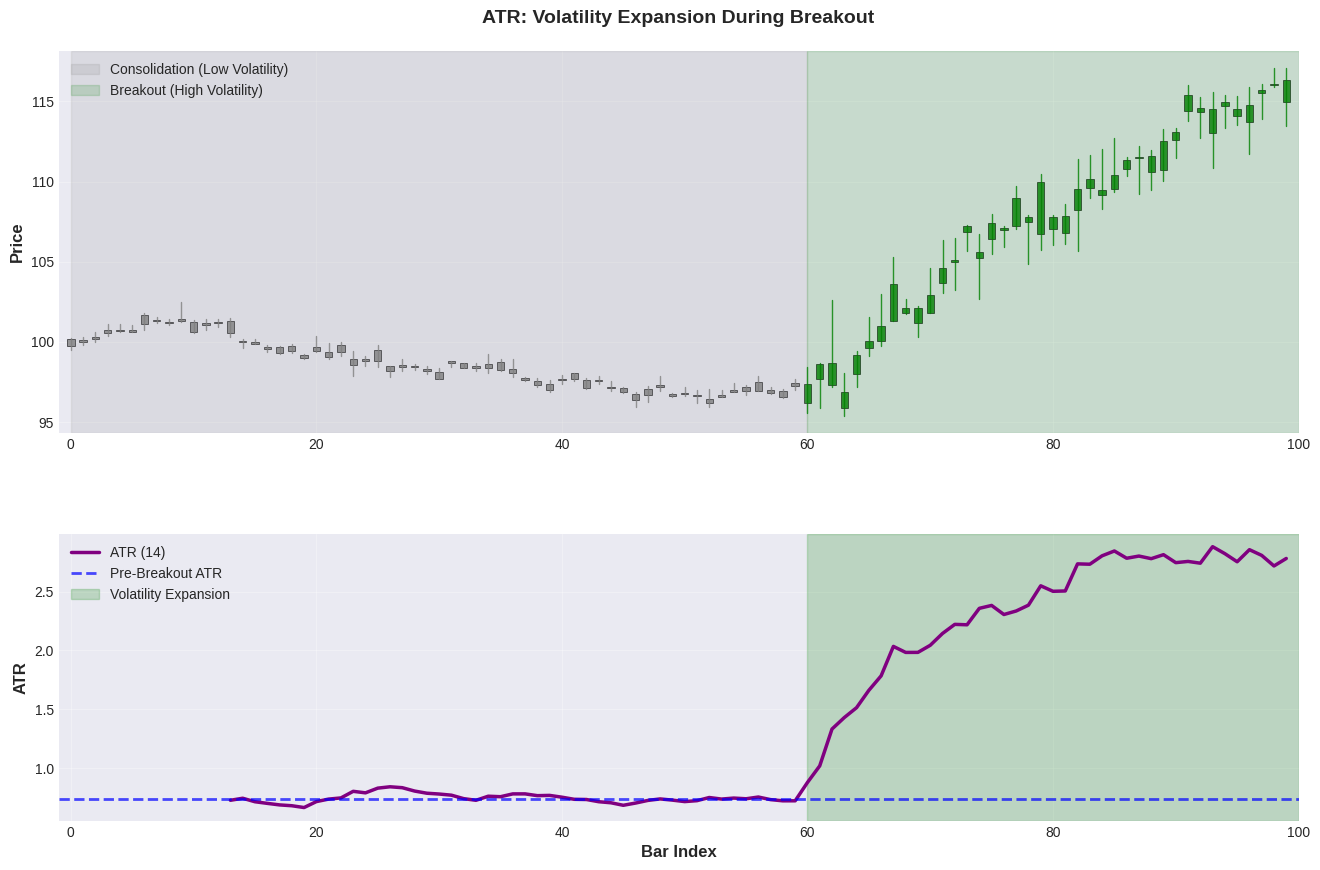

Pre-breakout ATR: 0.74
Post-breakout ATR: 2.50

ATR increased by 239.6% during breakout!


In [2]:
# Consolidation then breakout with volatility expansion
n = 100
dates = pd.date_range('2024-01-01 09:30', periods=n, freq='5min')

# Price: consolidation then breakout
consolidation = 100 + np.cumsum(np.random.randn(60) * 0.3)
breakout = consolidation[-1] + np.cumsum(np.ones(40) * 0.5 + np.random.randn(40) * 0.8)
closes = np.concatenate([consolidation, breakout])

# Volatility: low during consolidation, high during breakout
volatility_mult = np.concatenate([np.ones(60) * 0.3, np.ones(40) * 1.2])
opens = closes + np.random.randn(n) * volatility_mult
highs = np.maximum(opens, closes) + np.abs(np.random.randn(n)) * volatility_mult
lows = np.minimum(opens, closes) - np.abs(np.random.randn(n)) * volatility_mult

df = pd.DataFrame({'high': highs, 'low': lows, 'close': closes}, index=dates)
result = atr(df, window=14)

# Plot
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 1, height_ratios=[2, 1.5], hspace=0.3)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)

# Candlesticks
for i in range(len(df)):
    color = 'green' if i >= 60 else 'gray'
    ax1.plot([i, i], [df['low'].iloc[i], df['high'].iloc[i]], color=color, linewidth=1, alpha=0.8)
    height = abs(df['close'].iloc[i] - opens[i])
    if height < 0.05: height = 0.1
    bottom = min(opens[i], df['close'].iloc[i])
    ax1.add_patch(plt.Rectangle((i-0.3, bottom), 0.6, height, facecolor=color, edgecolor='black', linewidth=0.5, alpha=0.8))

ax1.axvspan(0, 60, alpha=0.15, color='gray', label='Consolidation (Low Volatility)')
ax1.axvspan(60, 100, alpha=0.15, color='green', label='Breakout (High Volatility)')
ax1.set_ylabel('Price', fontsize=12, fontweight='bold')
ax1.set_title('ATR: Volatility Expansion During Breakout', fontsize=14, fontweight='bold', pad=20)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-1, len(df))

# ATR
atr_vals = result['atr'].values
ax2.plot(range(len(atr_vals)), atr_vals, 'purple', linewidth=2.5, label='ATR (14)')
ax2.axhline(atr_vals[55], color='blue', linestyle='--', linewidth=2, label='Pre-Breakout ATR', alpha=0.7)
ax2.axvspan(60, 100, alpha=0.2, color='green', label='Volatility Expansion')
ax2.set_xlabel('Bar Index', fontsize=12, fontweight='bold')
ax2.set_ylabel('ATR', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(-1, len(df))

plt.tight_layout()
plt.show()

pre_breakout_atr = atr_vals[55]
post_breakout_atr = atr_vals[80]
atr_increase = ((post_breakout_atr / pre_breakout_atr) - 1) * 100
print(f"Pre-breakout ATR: {pre_breakout_atr:.2f}")
print(f"Post-breakout ATR: {post_breakout_atr:.2f}")
print(f"\nATR increased by {atr_increase:.1f}% during breakout!")

## Scenario 2: Position Sizing with ATR
Use ATR for risk-adjusted position sizing

/tmp/sselcuk/ipykernel_1244237/1269976848.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


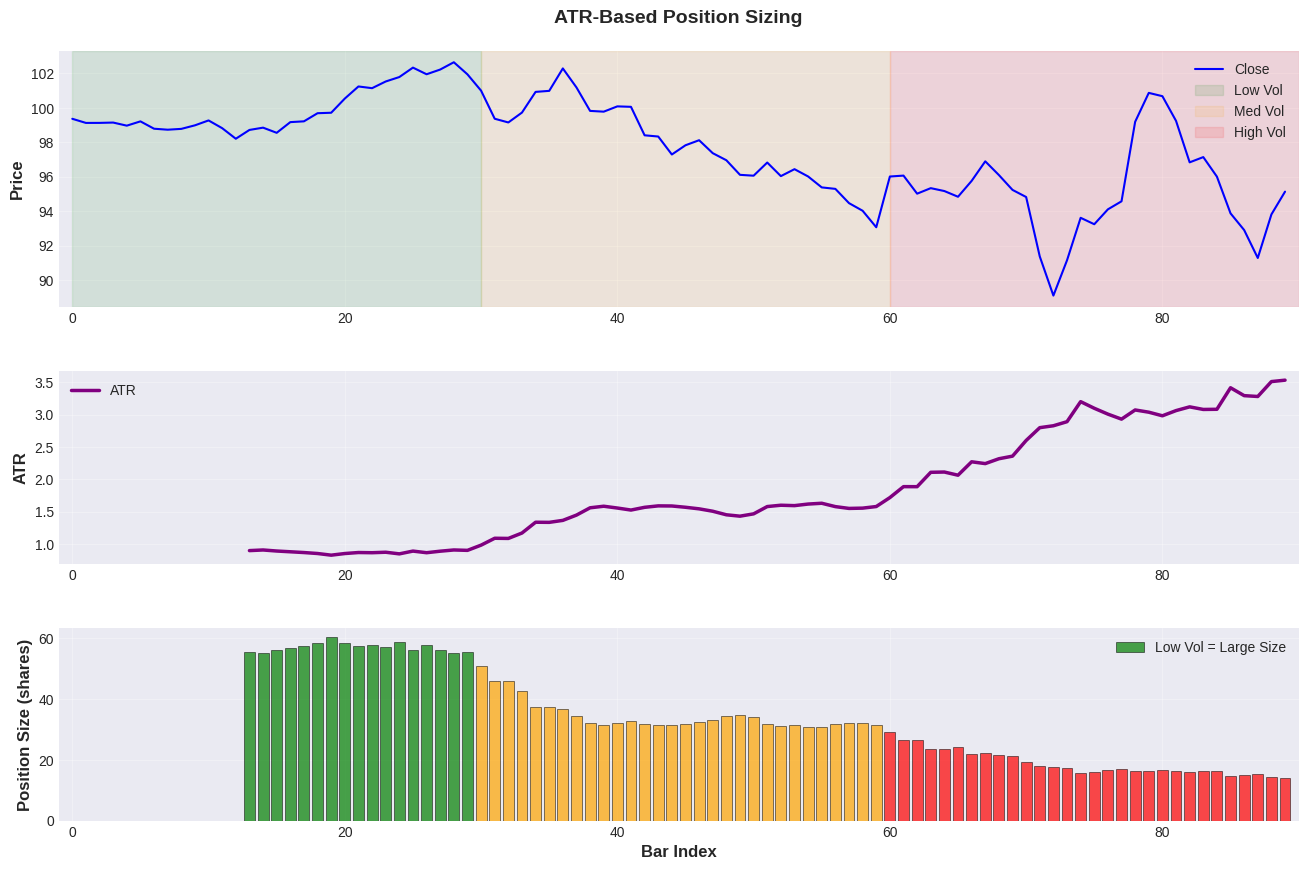

Position size in low volatility: 56 shares
Position size in high volatility: 16 shares

Lower position size in high volatility = Consistent risk!


In [3]:
# Varying volatility regime
n2 = 90
dates2 = pd.date_range('2024-01-01 10:00', periods=n2, freq='5min')

# Three regimes: low, medium, high volatility
volatility = np.concatenate([
    np.ones(30) * 0.4,   # Low volatility
    np.ones(30) * 0.8,   # Medium volatility
    np.ones(30) * 1.5    # High volatility
])

closes2 = 100 + np.cumsum(np.random.randn(n2) * volatility)
opens2 = closes2 + np.random.randn(n2) * volatility * 0.5
highs2 = np.maximum(opens2, closes2) + np.abs(np.random.randn(n2)) * volatility
lows2 = np.minimum(opens2, closes2) - np.abs(np.random.randn(n2)) * volatility

df2 = pd.DataFrame({'high': highs2, 'low': lows2, 'close': closes2}, index=dates2)
result2 = atr(df2, window=14)

# Calculate position sizes (inverse of ATR)
risk_per_trade = 100  # Risk $100 per trade
atr_vals2 = result2['atr'].values
position_sizes = risk_per_trade / (2 * atr_vals2)  # 2x ATR stop
position_sizes = np.nan_to_num(position_sizes, nan=0)

fig = plt.figure(figsize=(16, 10))
gs = GridSpec(3, 1, height_ratios=[2, 1.5, 1.5], hspace=0.3)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax3 = fig.add_subplot(gs[2], sharex=ax1)

# Price
ax1.plot(range(len(df2)), closes2, 'blue', linewidth=1.5, label='Close')
ax1.axvspan(0, 30, alpha=0.1, color='green', label='Low Vol')
ax1.axvspan(30, 60, alpha=0.1, color='orange', label='Med Vol')
ax1.axvspan(60, 90, alpha=0.1, color='red', label='High Vol')
ax1.set_ylabel('Price', fontsize=12, fontweight='bold')
ax1.set_title('ATR-Based Position Sizing', fontsize=14, fontweight='bold', pad=20)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-1, len(df2))

# ATR
ax2.plot(range(len(atr_vals2)), atr_vals2, 'purple', linewidth=2.5, label='ATR')
ax2.set_ylabel('ATR', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(-1, len(df2))

# Position Size
colors = ['green' if i < 30 else 'orange' if i < 60 else 'red' for i in range(len(df2))]
ax3.bar(range(len(df2)), position_sizes, color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
ax3.set_xlabel('Bar Index', fontsize=12, fontweight='bold')
ax3.set_ylabel('Position Size (shares)', fontsize=12, fontweight='bold')
ax3.legend(['Low Vol = Large Size', 'Med Vol = Med Size', 'High Vol = Small Size'])
ax3.grid(True, alpha=0.3)
ax3.set_xlim(-1, len(df2))

plt.tight_layout()
plt.show()

avg_size_low = position_sizes[25]
avg_size_high = position_sizes[75]
print(f"Position size in low volatility: {avg_size_low:.0f} shares")
print(f"Position size in high volatility: {avg_size_high:.0f} shares")
print(f"\nLower position size in high volatility = Consistent risk!")

## Key Takeaways

**ATR Applications:**
- **Stop-Loss Placement**: Use 2-3x ATR from entry
- **Position Sizing**: Reduce size when ATR is high
- **Breakout Confirmation**: Rising ATR validates breakouts
- **Trailing Stops**: Trail stops by 2x ATR distance

**Window Selection:**
- **14 (default)**: Standard for daily/swing trading
- **7-10**: More responsive for intraday
- **20-30**: Smoother for position trading

**Trading Rules:**
1. **Stop-Loss**: Entry ± (2.0 × ATR)
2. **Position Size**: Risk / (2 × ATR)
3. **Breakout Filter**: Only trade if ATR rising
4. **Range Days**: Avoid when ATR < 20-day average

**Best Practices:**
- ATR measures volatility, NOT direction
- Combine with price action for entries
- Adjust position size inversely with ATR
- Use multiple timeframes (e.g., daily and hourly ATR)
- Monitor ATR expansion for potential reversals

## Feature Showcase: Safety & Configuration

In [4]:
# Configuration & Validation Showcase
# ---------------------------------------------------------
import pandas as pd
import numpy as np
from indikator import atr

# 1. Configuration with .Config()
print(f"--- Custom atr Configuration ---")
# Create a fully configured version of the indicator
# This factory pattern validates parameters at creation time
custom_atr = atr.Config(window=21).make()
print(f"Created: {custom_atr}")

# 2. Validation Safety
print(f"--- Input Validation Safety ---")
try:
    # Attempt to use invalid data (missing columns)
    invalid_data = pd.DataFrame({'close': [100, 101, 102]}) # Missing high/low
    print("Attempting calculation with invalid inputs...")
    atr(invalid_data)
except Exception as e:
    # The @validated decorator automatically catches the issue
    print(f"✓ Validator caught error as expected: {e}")


--- Custom atr Configuration ---
Created: atr(window=21)
--- Input Validation Safety ---
Attempting calculation with invalid inputs...
✓ Validator caught error as expected: Validation failed for parameter 'data' in 'atr' (HasColumns): Missing columns: ['high', 'low']
